# Numerical methods project
*This Notebook has been created by Clément Caillaud*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

plt.rc('font',serif='Times', family='serif', weight='normal')

params = {
   'axes.labelsize': 14,
   'legend.fontsize': 14,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': (6,4),
   'figure.dpi': 100
   }
plt.rcParams.update(params)

## The 1D linear advection equation

We consider here the linear advection of a scalar $\phi(t,x)$ in a domain $\Omega$ closed by periodic boundaries $\partial \Omega$. We aim to study the diffusive and dispersive properties of numerical schemes

$$\frac{\partial \phi}{\partial t} - a\frac{\partial \phi}{\partial x} = 0 $$

The scalar initial distribution $\phi_0(t=0,x)$ is advected through the domain 10 times and the diffusion and dispersion errors of the numerical methods are assessed.

In [2]:
Nx = 512
ng = 2
x_min = -1.0
x_max = np.abs(x_min)
a  = 2.0


x = np.linspace(x_min, x_max, Nx)
dx = np.abs(np.diff(x))
t_max = 5*(x_max-x_min)/a

cfl = 0.1
dt = cfl * dx[0] / a

i_s = 2
i_e = Nx+ng

### Initial solution

We define here $\phi_0=\phi(t=0,x)$. Any periodic initial distribution can be chosen.

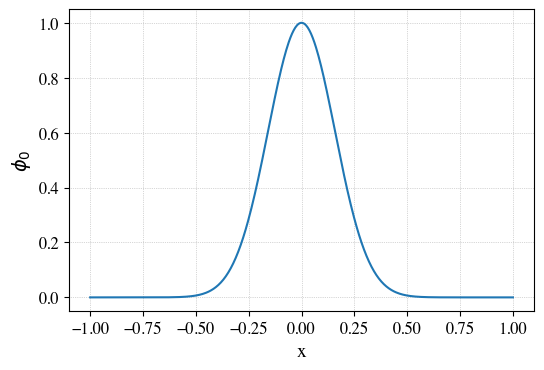

In [9]:
#Initial solution array
phi_0 = np.exp(-x**2/0.05)

plt.figure(dpi=100)
plt.plot(x, phi_0);
plt.grid(linewidth=0.5, linestyle=':')
plt.xlabel(r'x');
plt.ylabel(r'$\phi_0$');

In [4]:
#Creating ghost-cells for easy BC integration
ng_r = np.zeros(ng)
ng_l = np.zeros(ng)

phi_0 = np.concatenate((ng_l, phi_0, ng_r))
print(phi_0[i_s:i_e].shape, x.shape)

#Building the necessary additional arrays
phi = phi_0.copy()
phi_n = phi.copy() * 0.0

(512,) (512,)


### Routines definition
Here are defined the functions dedicated to the spatial part of the numerical scheme. Especially the boundary conditions and the spatial scheme $f(\phi^n)$

In [5]:
#Quick periodic BC applied to the ghost-cells
def bc_periodic(phi):
    phi[0:i_s] = np.roll(phi.copy(),2*ng+1)[0:i_s]
    phi[i_e:Nx+2*ng+1] = np.roll(phi.copy(),-2*ng-1)[i_e:Nx+2*ng+1]
    
    return phi

@jit(nopython=True) #Directive for just-in-time compilation of intensive python loop (can be suppressed)
def numerical_scheme(phi_n,phi,a,dt,dx,imin,imax):
    for i in range(imin, imax+1):
        phi_n[i] = phi[i] - dt * a * (phi[i] - phi[i-1]) / (dx) +#+ ((a*dt)**2/(2*dx**2))*(phi[i+1] - 2.0*phi[i] + phi[i-1])
    
    return phi_n

#Utility function to check eventual divergence in the computation
def divergence(phi):
    divergence = False
    if np.NAN in phi : divergence = True
    if np.inf in phi : divergence = True
    
    return divergence

#Utility function to compute the L2 error of the solution
def L2_error(phi,phi_0):
    return np.sqrt(1.0/Nx * np.sum((phi[i_s:i_e] - phi_0[i_s:i_e])**2))

### Solver loop
We are solving the discretized equation with the temporal and spatial schemes, giving : $\phi^{n+1} = f(\phi^n)$. 

The boundary conditions are applied and the physical time is monitored

In [6]:
t = 0.0
ite = 0
while t < t_max :
    
    phi_n[:] = 0.0

    #phi[0:i_s] = phi[i_e-ng:i_e]
    #phi[i_e:Nx+2*ng+1] = phi[i_s:i_s+ng]
    
    bc_periodic(phi)
    
    #Update physical time
    if t+dt>t_max:
        dt = np.abs(t_max - t)
    else :
        t = t + dt
    
    #Compute the n+1 state of phi
    
    numerical_scheme(phi_n, phi, a, dt, dx=dx[0], imin=i_s, imax=i_e)
    
    #Periodic boundary conditions    
    ite +=1
    
    phi[:] = phi_n[:]
    
    if(divergence(phi)): 
        print ('Solution diverged')
        break
    
    #if ite > 200 :break 
        
t, dt, ite, L2_error(phi, phi_0)

(5.0, 2.525979425627156e-12, 25552, 0.12537049423724053)

### Computed solution
We compare the numerical solution obtained to the exact solution

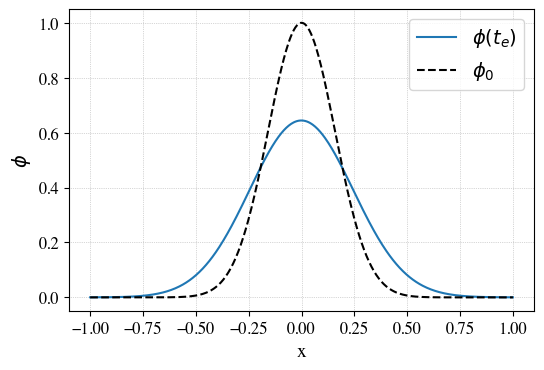

In [7]:
plt.plot(x, phi[i_s:i_e], label=r'$\phi(t_e)$')
plt.plot(x, phi_0[i_s:i_e], 'k--', label=r'$\phi_0$')
plt.grid(linewidth=0.5, linestyle=':')
plt.xlabel(r'x')
plt.ylabel(r'$\phi$')
plt.legend()

### Order of convergence

We graphicallly evaluate the order of convergence for our equation

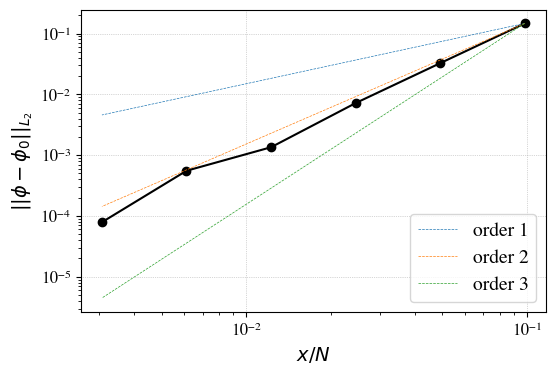

In [8]:
res = [0.14649491107218568, 0.032505372290624945, 0.007172850671163589, 0.0013485179922882945, 0.0005533478521061631, 7.892664626693056e-05 ]
dh = 1.0/np.asarray([64, 128, 256, 512, 1024, 2048])
plt.loglog(2.0*np.pi*dh, res, 'ko-')
plt.loglog(2.0*np.pi*dh,res[0]*(dh)/np.max(dh), '--', linewidth=0.5, label = 'order 1')
plt.loglog(2.0*np.pi*dh,res[0]*(dh**2)/np.max(dh**2), '--', linewidth=0.5, label = 'order 2')
plt.loglog(2.0*np.pi*dh,res[0]*(dh**3)/np.max(dh**3), '--', linewidth=0.5, label = 'order 3')
plt.xlabel(r'$x/N$')
plt.ylabel(r'$||\phi-\phi_0||_{L_2}$')
plt.grid(linewidth=0.5, linestyle=':')
plt.legend()